In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from fastMRI.data import transforms as T
from fastMRI.common.subsample import MaskFunc

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "data")
train_h5_files = glob.glob(os.path.join(TRAIN_DATASET_PATH,'singlecoil_train','*.h5'))
print(len(train_h5_files))

9


In [2]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sample_image_rss: output undersampled image
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    # 2. apply mask to kspace
    masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(masked_kspace)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. compute RSS to add all slices to one image
    sampled_image_rss = T.root_sum_of_squares(cropped_image, dim=0)
    
    # 7. convert torch tensor to good old numpy array
    sampled_image_rss = np.abs(sampled_image_rss.numpy())
    
    return sampled_image_rss


def recon_ground_truth(vol):
    '''
    Reconstructs ground truth image from gt tensor of shape (slices, w, h).    
    Args: 
        vol: hdf5 dataset of voulume (slices,w,h) from ESC or RSS
    Returns: 
        recon_img: img of shape w x h
    '''
    
    # Convert hdf5 dataset input volume to numpy arr
    vol = np.array(vol)
    # Convert numpy array to pytorch tensor
    slice_kspace2 = T.to_tensor(vol)
    # Combine slices into full image
    slice_image_rss = T.root_sum_of_squares(slice_kspace2, dim=0)
    # Convert image to good old numpy
    recon_img = np.abs(slice_image_rss.numpy())
    
    return recon_img


def recon_kspace(vol):
    '''
    Reconstructs entire upsampled image from kspace tensor of shape (slices, w, h).    
    Args:
        vol:hdf5 dataset kspace tensor of voulume slices x w x h
    Returns: 
        recon_kspace_img: img of shape w x h
    '''
    # Convert from numpy array to pytorch tensor
    kspace_tensor = T.to_tensor(vol)  
    # Apply Inverse Fourier Transform to get the complex image
    comp_img = T.ifft2(kspace_tensor)           
    # Compute absolute value to get a real image
    real_img = T.complex_abs(comp_img) 
    #print(real_img.shape)
    # Combine slices to full image
    image_rss = T.root_sum_of_squares(real_img, dim=0)
    # Numpy image
    recon_kspace_img = np.abs(image_rss.numpy())
    
    return recon_kspace_img

### Get a single MRI file

In [3]:
file = train_h5_files[8]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


In [4]:
# Create a mask function object for undersampling

mask_func = MaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])
mask_func_4x = MaskFunc(center_fractions=[0.08], accelerations=[4])
mask_func_8x = MaskFunc(center_fractions=[0.04], accelerations=[8])  

### 1. Kspace tensor

In [5]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)

(35, 640, 372)


In [6]:
img_4x = sub_sample_kspace(kspace_tensor, mask_func_4x)
img_4x.shape

(320, 320)

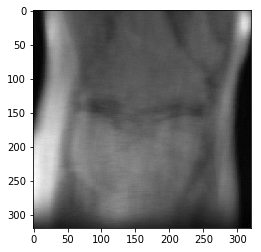

In [7]:
plt.imshow(img_4x, cmap='gray')

### 2. Ground truth 

In [8]:
gt_rss = hf['reconstruction_rss']
gt_rss.shape

(35, 320, 320)

In [9]:
y = recon_ground_truth(gt_rss)
y.shape,

((320, 320),)

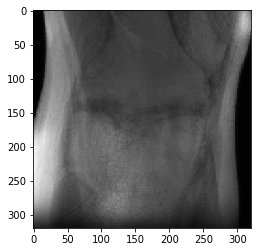

In [10]:
plt.imshow(y, cmap='gray')

In [11]:
y.shape

(320, 320)

In [12]:
#plt.imsave("y.jpg", y, cmap='gray')

### Construct dataset for low and high resolution MRI scans

In [13]:
# Create a mask function object for undersampling

# randomly sample 4x and 8x accelerations
mask_func = MaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])

# 4x
mask_func_4x = MaskFunc(center_fractions=[0.08], accelerations=[4])

# 8x
mask_func_8x = MaskFunc(center_fractions=[0.04], accelerations=[8])  

In [14]:
# Make folder for low and high res

LOW_DIR = "singlecoil_train_images_48x/low/"
HIGH_DIR = "singlecoil_train_images_48x/high/"

H.create_directory("{}/{}".format(TRAIN_DATASET_PATH, LOW_DIR))
H.create_directory("{}/{}".format(TRAIN_DATASET_PATH, HIGH_DIR))

In [15]:
# file1000015.h5 gave OSError!!!!

In [16]:
LOW_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, LOW_DIR)
HIGH_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, HIGH_DIR)
LOW_DIR_PATH, HIGH_DIR_PATH

('/home/hasib/MRI-reconstruction/data/singlecoil_train_images_48x/low/',
 '/home/hasib/MRI-reconstruction/data/singlecoil_train_images_48x/high/')

In [18]:
i=0
for file in train_h5_files:
    
    hf = h5py.File(file)
    
    # transform and save low res image
    kspace_tensor = hf['kspace'][()]
    img_4x = sub_sample_kspace(kspace_tensor, mask_func) # define maks function
    plt.imsave("{}/{}_low.jpg".format(LOW_DIR_PATH, i), img_4x, cmap='gray')
    
    
    # transform and save ground truth(RSS)
    gt_rss = hf['reconstruction_rss']
    img_gt = recon_ground_truth(gt_rss)
    plt.imsave("{}/{}_high.jpg".format(HIGH_DIR_PATH, i), img_gt, cmap='gray')
    
    print(i, kspace_tensor.shape, "--", img_4x.shape, "--", gt_rss.shape, "--", img_gt.shape)
    i+=1

0 (38, 640, 368) -- (320, 320) -- (38, 320, 320) -- (320, 320)
1 (34, 640, 368) -- (320, 320) -- (34, 320, 320) -- (320, 320)
2 (34, 640, 368) -- (320, 320) -- (34, 320, 320) -- (320, 320)
3 (45, 640, 368) -- (320, 320) -- (45, 320, 320) -- (320, 320)
4 (36, 640, 372) -- (320, 320) -- (36, 320, 320) -- (320, 320)
5 (32, 640, 372) -- (320, 320) -- (32, 320, 320) -- (320, 320)
6 (36, 640, 368) -- (320, 320) -- (36, 320, 320) -- (320, 320)
7 (35, 640, 368) -- (320, 320) -- (35, 320, 320) -- (320, 320)
8 (35, 640, 372) -- (320, 320) -- (35, 320, 320) -- (320, 320)
